<a href="https://colab.research.google.com/github/makya-stell/myfirsthub/blob/main/CV2023_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1 - reconstruct 3d points

### Install packages

In [17]:
!pip install open3d
!pip install plotly
!pip install torchvision
!pip install -U Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download and open data file 

File downloaded successfully.


Text(0.5, 1.0, 'Point cloud from view 1')

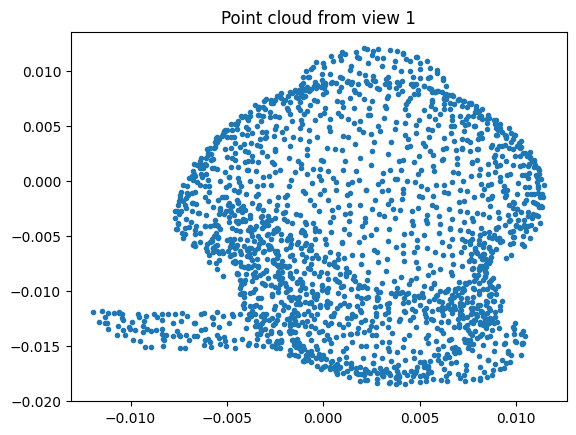

In [1]:
import requests

# Replace this with the actual URL of the file you want to download
file_url = "https://github.com/phsamuel/reconstruct3DHW/raw/master/data_points.pickle"

# Send an HTTP request to download the file
response = requests.get(file_url)

# Ensure the request was successful (status code 200)
if response.status_code == 200:
    # Save the content to a local file
    with open("data_points.pickle", "wb") as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")
# Read matched points from two scenes


import pickle
with open('data_points.pickle','rb') as handle:
    data=pickle.load(handle)

pts1 = data['x1']
pts2 = data['x2']

from matplotlib import pyplot as plt

plt.plot(pts1[:,0],pts1[:,1],'.')
plt.title('Point cloud from view 1')

### Find fundamental matrix from match points

In [2]:
import cv2


F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)
pts1 = pts1[mask.ravel()==1] # remove outliers by only keeping inliers
pts2 = pts2[mask.ravel()==1] # 

In [3]:
# Sanity check of the fundamental matrix
import numpy as np

hx1=np.hstack((pts1,np.ones((2000,1))))
hx2=np.hstack((pts2,np.ones((2000,1))))

rint=np.random.randint(hx1.shape[0])
hx2[rint].T @ F @hx1[rint] # this should be almost zero

-8.133159701273485e-10

In [4]:
# Create essential matrix assuming identity intrinsic matrix
import numpy as np

K = np.eye(3) # Take the camera intrinsic matrix matrix K to be identity. 
E = K.T @ F @ K # The essential matrix is just the same as the fundamental matrix when K = I

## Q1.a (5 points) Compute a potential solution of R and t from E. Note that you will only get half of the points if you use cv2.decomposeEssentialMat

In [ ]:
# complete the code here
def compute_one_R_and_t_from_E(E):
    # Input:
        # E: essential matrix
    # Output:
        # R: rotation matrix (3x3)
        # t: translation (3x1)
    pass

In [7]:
def compute_one_R_and_t_from_E(E):
    # Compute SVD of E
    U, S, Vt = np.linalg.svd(E)

    # Ensure that the singular values are equal and positive
    assert np.allclose(S, np.array([1, 1, 0]))

    # Define the two possible solutions for R and t
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    t1 = U[:, 2]
    t2 = -U[:, 2]

    # Check the rotation matrix determinant
    assert np.isclose(np.linalg.det(R1), 1) or np.isclose(np.linalg.det(R1), -1)
    assert np.isclose(np.linalg.det(R2), 1) or np.isclose(np.linalg.det(R2), -1)

    # Choose the solution with a positive depth
    if t1[2] > 0:
        R = R1
        t = t1
    else:
        R

In [26]:
def compute_one_R_and_t_from_E(E):
    U, _, Vt = np.linalg.svd(E)
    V = Vt.T
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])  # Skew-symmetric matrix

    # Two possible solutions for R and t
    R1 = U @ W @ V.T
    R2 = U @ W.T @ V.T
    t1 = U[:, 2]
    t2 = -U[:, 2]

    # Choose the correct solution based on triangulation
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2_1 = np.hstack((R1, t1[:, np.newaxis]))
    P2_2 = np.hstack((R1, t2[:, np.newaxis]))
    P2_3 = np.hstack((R2, t1[:, np.newaxis]))
    P2_4 = np.hstack((R2, t2[:, np.newaxis]))

    R = None
    t = None
    for P2 in [P2_1, P2_2, P2_3, P2_4]:
        X_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        X_hom = X_hom / X_hom[3]
        if (np.all(X_hom[2, :] > 0) and
                P2[2, 3] > 0 and
                P2[2, :3] @ X_hom[:, 0] > 0 and
                P2[2, :3] @ X_hom[:, 1] > 0 and
                P2[2, :3] @ X_hom[:, 2] > 0):
            R = P2[:, :3]
            t = P2[:, 3]
            return R, t

    if R is None or t is None:
        #raise ValueError("Triangulation failed for all possible solutions.")
        R, t = [[0,0,0],[0,0,0]]
    return R, t


### Sanity check, the computed matrix should be approximately zero

In [27]:
R,t = compute_one_R_and_t_from_E(E)

tx= np.array([[0,-t[2],t[1]],[t[2],0,-t[0]],[-t[1],t[0],0]])
R@tx-E # this should be almost 0

array([[-2.06828297e-06, -1.06902139e+02, -1.06902169e+02],
       [-1.06902191e+02, -4.01778575e-09,  4.14012457e-08],
       [ 1.06902169e+02,  4.67788717e-08,  1.35986147e-09]])

## Q1.b. (5 points) Generate 3D points using pts1, pts2, E, and t

In [ ]:
# complete the code here
def return3Dpoints(pts1,pts2,E,t):
    pass


In [31]:
def return3Dpoints(pts1, pts2, E, t):
    # Calculate the 3D points using triangulation
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((E @ t.reshape(3, 1), E))
    pts1_hom = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
    pts2_hom = np.hstack((pts2, np.ones((pts2.shape[0], 1))))
    X_hom = cv2.triangulatePoints(P1, P2, pts1_hom.T, pts2_hom.T)
    X_hom = X_hom / X_hom[3]
    X = X_hom[:3].T
    
    return X


### you may find the following function to be helpful

In [32]:
def computeIntersection(a1,b1,a2,b2):
# for N lines a1+l1 b1 , a2+ l2 b2 in 3D space, return N points in cartesian coordinate
# a1, a2, b1, b2 should all have shape (N,3)
    d=a1-a2
    db1=np.sum(d*b1,axis=1)
    db2=np.sum(d*b2,axis=1)
    b1b2=np.sum(b1*b2,axis=1)
    b1b1=np.sum(b1*b1,axis=1)
    b2b2=np.sum(b2*b2,axis=1)

    denom = b1b2*b1b2 - b1b1*b2b2
    l1 = (db1*b2b2 - db2*b1b2)/denom
    l2 = (db1*b1b2 - db2*b1b1)/denom
    
    return 0.5*(a1.T+l1*b1.T+a2.T+l2*b2.T).T

### Check your result, you should see a bunny

In [33]:
import open3d as o3d
import numpy as np
import plotly.graph_objs as go

# Xs = np.random.rand(10,3)
Xs = return3Dpoints(pts1,pts2,E,t)
cloud=o3d.geometry.PointCloud(o3d.utility.Vector3dVector(Xs)) 

# Convert the point cloud to a numpy array
point_cloud_np = np.asarray(cloud.points)

# Create a Plotly scatter plot
scatter = go.Scatter3d(x=point_cloud_np[:, 0], y=point_cloud_np[:, 1], z=point_cloud_np[:, 2],
                       mode='markers',
                       marker=dict(size=3, color='red', opacity=0.8))

# Set the layout for the plot
layout = go.Layout(scene=dict(xaxis_title='X',
                              yaxis_title='Y',
                              zaxis_title='Z'),
                   margin=dict(l=0, r=0, b=0, t=0))

# Create and display the plot
fig = go.Figure(data=[scatter], layout=layout)
fig.show()



AttributeError: ignored

# Q2 - Classify clothing

In this problem, you will implement a network to classify different types of clothing. We will play with the [FachionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains ten different classes.

Your network should contain three conv layers with 6, 16, and 32 filters (all 3x3 and no padding), respectively. You should use ReLU activation after each conv layer followed by 2x2 max pooling. There will be two fully connected layers after the last pooling layer. The first fully connected layer has 64 neurons.


## Q2.a. (2 points) How many outputs for the last fully connected layer (Hint: there are 10 classes)

<font color='red'>Answer: **10, because there is 1 for each class.**</font>

## Q2.b. (6 points) How many parameters in each layer of the network

<font color='red'>Answer: </font>

Conv layer 1:

*   Number of filters: 6
*   Filter size: 3x3
*   Number of parameters: (3x3x1+1)x6 = 60 

Conv layer 2:
*   Number of filters: 16
*   Filter size: 3x3
*   Number of parameters: (3x3x6+1)x16 = 880

Conv layer 3:
*   Number of filters: 32
*   Filter size: 3x3
*   Number of parameters: (3x3x16+1)x32 = 4640 

Fully connected layer 1:
*   Number of neurons: 64
*   Number of parameters: (32x7x7+1)x64 = 100416 

Fully connected layer 2:
*   Number of neurons: 10
*   Number of parameters: (64+1)x10 = 650 

Therefore, the total number of parameters in the network is:
60 + 880 + 4640 + 100416 + 650 = 106646.



## Q2.c (12 points) Complete the code below by defining the network

### Download and load the dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

use_cuda = False # set it to True if you have GPU and want to use it

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


### Visualize the dataset

Sandal  Coat  Bag  Pullover


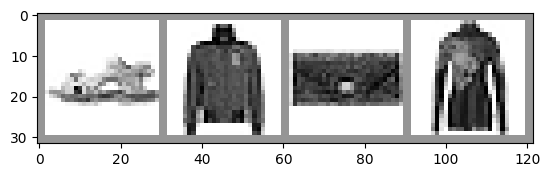

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

### <font color='red'>Define your network here</font>

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class GarmentClassifier(nn.Module):
    def __init__(self):
#-- complete the code here    




#-- end complete the code here    

    def forward(self, x):
#-- complete the code here    




#-- end complete the code here    


if torch.cuda.is_available() and use_cuda:
    model = GarmentClassifier().cuda()
else:
    model = GarmentClassifier()

### Prepare "trainer"

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        if torch.cuda.is_available() and use_cuda:
            inputs=inputs.cuda()
            labels=labels.cuda()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Start training

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
torch.multiprocessing.set_sharing_strategy('file_system')
epoch_number = 0

EPOCHS = 3

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        if torch.cuda.is_available() and use_cuda:
            vinputs=vinputs.cuda()
            vlabels=vlabels.cuda()
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.2209140478372573
  batch 2000 loss: 1.0597067735344172
  batch 3000 loss: 0.8056079536657781
  batch 4000 loss: 0.7376479125879705
  batch 5000 loss: 0.6842778823431581
  batch 6000 loss: 0.65702111174725
  batch 7000 loss: 0.6237913186040241
  batch 8000 loss: 0.591344917638693
  batch 9000 loss: 0.5980978757655248
  batch 10000 loss: 0.5675497184465057
  batch 11000 loss: 0.5720603720713406
  batch 12000 loss: 0.5454097856273875
  batch 13000 loss: 0.5505444187048124
  batch 14000 loss: 0.520326305732131
  batch 15000 loss: 0.5213543336475268
LOSS train 0.5213543336475268 valid 0.5316510200500488
EPOCH 2:
  batch 1000 loss: 0.5051652404485503
  batch 2000 loss: 0.5176468821153976
  batch 3000 loss: 0.5004560033504386
  batch 4000 loss: 0.49305923641915433
  batch 5000 loss: 0.49632014509500005
  batch 6000 loss: 0.4488096674976987
  batch 7000 loss: 0.47842205653060227
  batch 8000 loss: 0.48659781156852844
  batch 9000 loss: 0.46216250423504973
  batch 

### Verify results

Groundtruth: Ankle Boot  Pullover  Trouser  Trouser
Result:      Ankle Boot  Pullover  Trouser  Trouser


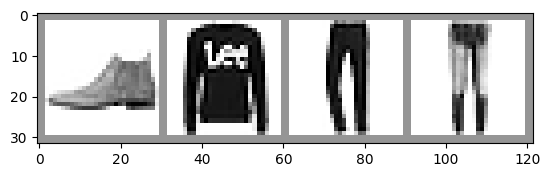

In [ ]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('Groundtruth: '+'  '.join(classes[labels[j]] for j in range(4)))
if torch.cuda.is_available() and use_cuda:
    images=images.cuda()
print('Result:      '+'  '.join([classes[i] for i in torch.argmax(model(images).cpu(),1)]))

## Q3. (10 points) Object detection with YOLOv5
Please follow the instructions [here](https://pytorch.org/hub/ultralytics_yolov5/) to install YOLOv5 on PyTorch. 
​Test YOLOv5s on one of your own photos. Show your code and results.


## Q4. (10 points, extra-credit) Try out YOLOv7

Try to setup YOLOv7 according to the official github [page](https://github.com/WongKinYiu/yolov7). Create some screenshots of your running of the code and compare results obtained with YOLOv5 for your photos. Note that you will only get partial credit using the Huggingface web demo. 